# Solving the Sawyer-Eliassen Equation

Author: Clairisse Reiher (clairisse.reiher@colorado.edu)

Last updated: September 20, 2024

This notebook demonstrates how to solve the Sawyer-Eliassen equation to yield a plot of the  ageostrophic, secondary circulation along a vertical cross-section through a frontal zone.

### ERA5 Data
This code is set up to perform the inversion using data from the ECMWF's ERA5 Reanalysis. The data is pulled from the *ERA5 hourly data pressure levels from 1940 to present* product.
- See data on pressure levels [here](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels?tab=overview)
- See data on single levels here [here](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview)

Clicking "Show API Request Code" at the bottom of either of these pages will provide you the code to use when downloading the file using the CDS API.

### The Sawyer-Eliassen Equation
The Sawyer-Eliassen equation can be written as:

$$
\left(-\gamma \frac{\partial \theta}{\partial p}\right) \frac{\partial^2 \psi}{\partial y^2} + \left(2 \frac{\partial M}{\partial p}\right) \frac{\partial^2 \psi}{\partial p \partial y} + \left(-\frac{\partial M}{\partial y}\right) \frac{\partial^2 \psi}{\partial^2 p} = Q_g - \gamma \frac{\partial}{\partial y}\left(\frac{d\theta}{dt}\right) \label{SE}\tag{1}
$$

where:
- $\psi$ = the Sawyer-Eliassen streamfunction
- $\gamma$ = a thermodynamic constant (more on that later)
- $M$ = absolute geostrophic momentum
- $p$ = pressure
- $Q_g$ = geostrophic forcing for the circulation
- $\theta$ = potential temperature

What even are some of these things in this equation? I'll explain below. Don't worry about $\gamma$ for now (you'll see how it gets calculated later).

First off, $\psi$ is the thing we're solving for. $\psi$ is a streamfunction, or a scalar value that provides the shape and direction of the circulation. Flow within the circulation moves tangent to contours of $\psi$. All that is to say that if we have $\psi$, we can calculate the velocity within the vertical and horizontal branches of the circulation.

Different parts of the equation control the shape, strength, and direction of this circulation. Suppose we rewrite the equation like this:

$$
A \frac{\partial^2 \psi}{\partial y^2} + B \frac{\partial^2 \psi}{\partial p \partial y} + C \frac{\partial^2 \psi}{\partial^2 p} = D \label{SEsimple}\tag{2}
$$

$A$, $B$, and $C$ are variable coefficients that control the shape of the circulation (for example, whether it appears more elongated in the horizontal or the vertical, or how tilted it appears in the vertical).
- $A$ represents static stability; weaker static stability results in longer vertical branches of the circulation
- $B$ represents the horizontal temperature gradient; stronger temperature gradient results in larger tilt into horizontal
- $C$ represents inertial stability; weaker inertial stability results in longer horizontal branches of the circulation

$D$ represents the forcing for the circulation, and controls the strength and direction of the circulation. A larger D translates to a stronger circulation).
- $D > 0$ causes a thermally direct circulation (rising motion on the warm side of the front, sinking motion on the cold side), which results from frontogenesis (strengthening of the horizontal temperature gradient)
- $D < 0$ causes a thermally indirect circulation (rising motion the cold side of the front, sinking motion on the warm side), which results from frontolysis (weakening of the horizontal temperature gradient)

$M$ is the absolute geostrophic momentum calculated as:

$$ M = U_g - fy $$

where $U_g$ = the component of the geostrophic wind in the x-direction, and $f$ = the Coriolis parameter. $M$ is a conserved quantity that determines how parcels of air in geostrophic balance move when they are horizontally displaced away from the front. This is similar to how changes in potential temperature with height (static stability) determine how parcels of air move when they are vertically displaced.

The geostrophic forcing $Q_g$ is most conveniently represented as the sum of two other forcing terms $Q_{SH}$ (a shearing term) and $Q_{ST}$ (a confluence term, sometimes also referred to as the "stretching" term, hence the convention "ST"). These are calculated as:

$$ Q_{SH} = 2 \gamma\left(\frac{\partial U_g}{\partial y} \frac{\partial \theta}{\partial x}\right) $$
$$ Q_{ST} = 2 \gamma\left(\frac{\partial V_g}{\partial y} \frac{\partial \theta}{\partial y}\right) $$

$Q_g$ is calculated as $Q_g = Q_{SH} + Q_{ST}$.

The final term on the right-hand side of ($\ref{SE}$), which reads $\gamma \frac{\partial}{\partial y}\left(\frac{d\theta}{dt}\right)$, represents the contribution of diabatic heating to the forcing of the circulation.



### Solving for $\psi$


Before solving the Sawyer-Eliassen equation, we need to take a vertical cross-section through the frontal zone positioned beneath the jet. The vertical cross-section must cut perpendicular to the frontal zone, and should cut through a portion of the jet that features little curvature (to obey assumptions that are used to derive the Sawyer-Eliassen equation). 

We will solve the Sawyer-Eliassen equation on a coordinate system defined based on this cross-section, where the $x$ axis in the coordinate system runs parallel to the front and the $y$ axis runs perpendicular to the front, oriented towards colder air.

To numerically solve the equation for $\psi$, we first have to convert all derivatives appearing on the left-hand side to expressions that can be numerically solved using finite differencing. Without going into too much explanation, doing so leads to a form of ($\ref{SEsimple}$) that looks like this:

\begin{align*}
\psi_{j,k} =& 
\left( \frac{-2A}{(\Delta y)^2} - \frac{2C}{(\Delta p)^2} \right)^{-1} \left[ D - \frac{A}{(\Delta y)^2}(\psi_{j+1,k} + \psi_{j-1,k}) \right. \\
& \left.- \frac{B}{4(\Delta p)(\Delta y)}(\psi_{j+1,k+1} - \psi_{j-1,k+1} - \psi_{j+1,k-1} + \psi_{j-1,k-1}) - \frac{C}{(\Delta p)^2}(\psi_{j,k+1} + \psi_{j,k-1}) \right]
\label{SEinverted}\tag{3}
\end{align*}

where $j$ and $k$ denote the $y$ and vertical directions, respectively. Equation ($\ref{SEinverted}$) is the form of the Sawyer-Eliassen equation that we'll use to solve for $\psi_{j,k}$, yielding the circulation that results from the forcing $D$. 

We can actually let $D$ equal any of the components which add together to give the full Sawyer-Eliassen forcing. This code allows $D$ to be set equal to the following forcing components:
1. $Q_g - \gamma \frac{\partial}{\partial y}\left(\frac{d\theta}{dt}\right)$ (full forcing due to geostrophic motion and diabatic heating)
2. $Q_g$ (full geostrophic frontogenesis/frontolysis)
3. $Q_{SH}$ (shearing contribution to geostrophic frontogenesis/frontolysis)
4. $Q_{ST}$ (confluence contribution to geostrophic frontogenesis/frontolysis)
5. $- \gamma \frac{\partial}{\partial y}\left(\frac{d\theta}{dt}\right)$ (diabatic heating)

Once we solve for $\psi$, we use the following equations to calculate the horizontal ($v_{SE}$) and vertical ($\omega_{SE}$) velocity in the circulation:
\begin{align*}
v_{SE} &= -\frac{\partial \psi}{\partial p}\\
\omega_{SE} &= \frac{\partial \psi}{\partial y}\\
\end{align*}


In [1]:
# Import all modules
import numpy as np
from datetime import datetime, timedelta
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.interpolate import cross_section 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps as cm
from matplotlib.ticker import NullFormatter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature


# Define function to compute the distance (dy) in meters between adjacent points on the y-axis of the 
# cross section used for solving the Sawyer-Eliassen circulation
#
# Inputs: 
#    lats, lons : 1D array-like
#       - Contains latitude and longitude coordinates in degrees at each point along the cross-section y-axis
# Outputs:
#     dy : 1D Numpy array
#       - Contains distance in meters between adjacent points on the cross section
def compute_dy(lats,lons):
    
    rE = 6.3781E6 #radius of the Earth
    
    dy = np.array([])
    
    #Iterate through each lat/lon and compute the great circle distance between the two points
    for i in range(len(lats)-1):
        
        #All angles must be in radians
        lat1 = np.radians(lats[i])
        lat2 = np.radians(lats[i+1])
        lon1 = np.radians(lons[i])
        lon2 = np.radians(lons[i+1])
    
        #Compute the great circle distance
        deltalon = lon2-lon1
        term1 = np.sin(lat1)*np.sin(lat2)
        term2 = np.cos(lat1)*np.cos(lat2)*np.cos(deltalon)
        centralangle = np.arccos(term1 + term2)
        dist = rE*centralangle
        
        #Save this distance (units: meters) into our output array
        dy = np.append(dy,dist)
    
    return dy

**Edit the code cell below** to tell the code some things about the data from which we will cut out the cross-section and use to solve the Sawyer-Eliassen equation, including:
- `time`: date and time of the data
- `latN`,`latS`,`lonW`, `lonE`: the northern, southern, western, and eastern bounds of the horizontal domain, in latitude and longitude (your cross section will cut through latitudes and longitudes within this domain)
- `level_bottom`, `level_top`: the pressure levels at the bottom and top of the domain, in hPa (these will also be the pressure levels at the bottom and top of our cross-section) 
- `csdapi_download`: which method to use when loading in the data

The code provides two different ways to open a file containing the data we'll use.
- Method 1: use `cdsapi_download = True` to download a file containing data from the ERA5 Reanalysis for a given time, domain, and list of pressure levels. Uses the Climate Data Store (CDS) API to do this. The downloaded file is then opened in the code.
- Method 2: use `cdsapi_download = False` to open a file that has already been downloaded, which you must provide the path to.

The bottom pressure level should be representative of the Earth's surface, and the top pressure level should be representative of the tropopause. This is to be physically consistent with the boundary conditions for the vertical branches of the circulation, which specify that $\omega = 0$ at all boundaries, including the top and bottom pressure levels (where $\omega$ is the vertical velocity in pressure coordinates).

In [2]:
# Choose time, domain, and list of pressure levels
time = '02/18/22 06:00'  # must be in format 'MM/DD/YY HH:00'
latN = 70                # northernmost latitude in domain, must be between 90º and -90º
latS = 15                # southernmost latitude in domain, must be between 90º and -90º
lonW = 250               # westernmost longitude in domain, must be between 0º and 360º
lonE = 310               # easternmost longitude in domain, must be between 0º and 360º

level_bottom  = 1000     # pressure level at bottom of domain, in hPa
level_top     = 100      # pressure level at top of domain, in hPa

# Choose which method to use for opening the data file (set to True or False)
cdsapi_download = False

In [3]:
########## ONLY RUN THIS CELL ONCE ###########

# Obtain datetime object from string containing time
time_dt = datetime.strptime(time,'%m/%d/%y %H:%M')

# Obtain datetime objects one hour ahead and one hour behind
time_plus1hr = time_dt + timedelta(hours = 1)
time_sub1hr  = time_dt - timedelta(hours = 1)

times = [time_sub1hr, time_dt, time_plus1hr]

# Create names for the three files we want to load in
filenames = ['era5_'+time.strftime('%Y%m%d_%H')+'00.nc' for time in times]

### Method 1
if cdsapi_download == True:
    
    # Download ERA5 data for entire globe at each specified time
    # Only download data at pressure level intervals of 50 hPa
    import cdsapi
    client = cdsapi.Client()
    dataset = "reanalysis-era5-pressure-levels"
    file_paths = []
    
    for i in range(0,len(filenames)):
        request = {
            'product_type': ['reanalysis'],
            'variable': ['geopotential', 'temperature', 'u_component_of_wind', 'v_component_of_wind', 'vertical_velocity'],
            'year': [times[i].strftime('%Y')],
            'month': [times[i].strftime('%m')],
            'day': [times[i].strftime('%d')],
            'time': [times[i].strftime('%H:00')],
            'pressure_level': [format(level,'d') for level in np.arange(level_top,level_bottom+50,50)],
            'data_format': 'netcdf',
            'download_format': 'unarchived'}
        client.retrieve(dataset, request, filenames[i])
    
        file_paths = file_paths + ['./'+filenames[i]]
    
    
### Method 2
else:
    
    # Insert the path to the three files, including the name of the file, into the strings below
    file_paths = ['./data_sawyer_eliassen/'+filename for filename in filenames]
    


# Load file into code corresponding to time at which we want to solve the Sawyer-Eliassen equation
file = xr.open_dataset(file_paths[1])

First we will load in some variables from ERA5 to plot a map that will help us identify a good cross-section to use. These variables include:
1. U component of wind
2. V component of wind
3. Geopotential height

ERA5 does not provide geopotential height, but it provides geopotential. All we have to do to convert geopotential to geopotential height is divide by gravitational acceleration.

The quantities we actually show on the plot will be:
- Wind speed at 250 hPa (calculated using U and V at 250 hPa). This will show us where any jet streaks are.
- 1000 - 500 hPa thickness (calculated using geopotential height at 1000 and 500 hPa). This will show us approximately where the front is through a vertical chunk of the troposphere.

In [4]:
# Load in variables we need and add units
u_3d = file['u'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
u_3d = u_3d * units.meter / units.second
v_3d = file['v'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
v_3d = v_3d * units.meter / units.second
gp_3d = file['z'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
gp_3d = gp_3d * (units.meter**2) / (units.second**2)

# Convert geopotential to geopotential height by dividing by gravity
gph_3d = gp_3d / (9.81 * units.meter / (units.second**2))
del gp_3d

# Calculate 250-hPa wind speed
spd_250 = ((u_3d.sel(pressure_level=250)**2) + (v_3d.sel(pressure_level=250)**2))**(1/2)

# Calculate 1000-500 hPa thickness
thick = gph_3d.sel(pressure_level=500) - gph_3d.sel(pressure_level=1000)

# Apply Gaussian smoothing in the latitude and longitude dimensions
# "degree" is an integer that adjusts the smoothing (a larger degree means more dramatic smoothing)
#degree = 25
#temp_3d = mpcalc.smooth_gaussian(temp_3d_era5, n=degree)
#gph_3d  = mpcalc.smooth_gaussian(gph_3d_era5, n=degree)

**Edit the code cell below** to tell the code the latitude/longitude coordinates for the start and end of the cross-section. The starting and end points are on the warm and cold sides of the front, respectively.

We'll then plot the cross-section over the 250-hPa wind speed and 1000-500 hPa thickness to make sure it meets the following criteria:
1. The cross-section must cut through a portion of the front with little curvature (and on the synoptic-scale, where the jet also features little curvature)
2. The cross-section should be oriented perpendicular to the front indicated by the 1000-500 hPa thickness
3. The cross-section should be reasonably long enough for the start and end points not the cut off part of the ageostrophic circulation (might be hard to determine what an appropriate length is until after you solve for the circulation)

If the cross-section you plot doesn't meet these criteria, then you can change the latitude/longitude coordinates for the start and end until you get a cross-section that looks good!

The variables in the code to change are:
- `start_lat`: latitude of starting point for cross-section
- `start_lon`: longitude of starting point for cross-section
- `end_lat`: latitude of ending point for cross-section
- `end_lon`: longitude of ending point for cross-section

In [5]:
# Choose starting latitude/longitude and ending latitude/longitude for cross section
# Starting point is on the warm side of the front, ending point is on the cold side of the front
start_lat = 21.0
start_lon = -62.0
end_lat = 64.0
end_lon = -77.5

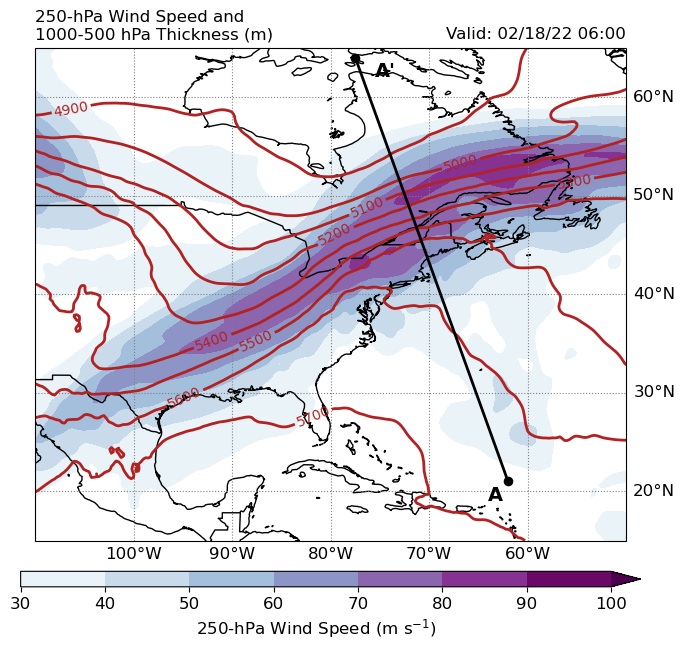

In [6]:
# Make the plot

# Set up projections used for the map and the data
mapcrs  = ccrs.PlateCarree(central_longitude= lonW + ((lonE-lonW)/2))
datacrs = ccrs.PlateCarree()

# Set contouring intervals
clev_spd   = np.arange(30,110,10)      # in meters/second
clev_thick = np.arange(4000,7000,100)   # in meters

# Set figure size
fig_map = plt.figure(figsize=(8,8))

# Create axes and set extent
ax_map = plt.axes(projection = mapcrs)
ax_map.set_extent([-110, -50, 15, 65], datacrs)

# Add geopolitical boundaries
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.BORDERS)

#Add gridlines and remove top + left labels
gridlines = ax_map.gridlines(color='gray',ls='dotted',draw_labels=True)
gridlines.top_labels  = False
gridlines.left_labels = False
gridlines.xlabel_style = {'size': 'large'}
gridlines.ylabel_style = {'size': 'large'}

# Add shading of wind speed
contf = ax_map.contourf(spd_250.longitude, spd_250.latitude, 
                        spd_250, 
                        clev_spd,
                        cmap=cm['BuPu'],
                        extend='max',
                        transform=datacrs)

# Add colorbar for omega shading
cbar = plt.colorbar(contf, orientation='horizontal', pad=0.05, aspect=40)
cbar.set_label(r'250-hPa Wind Speed (m s$^{-1}$)', size='large')
cbar.ax.tick_params(labelsize='large')
                  
# Add contours of thickness                 
cont = ax_map.contour(thick.longitude, thick.latitude, 
                      thick, 
                      clev_thick, 
                      colors='firebrick',
                      linewidths=2.0, transform=datacrs)
plt.clabel(cont, fontsize=10, inline=1, inline_spacing=3, rightside_up=True, use_clabeltext=True)  
                               
# Plot cross section using provided start and end coordinates
# Cross section will start at A and run to A'
plt.plot([start_lon, end_lon], [start_lat, end_lat], c='k', linewidth = 2.0, transform=datacrs)
plt.scatter([start_lon, end_lon], [start_lat, end_lat], c='k', s=35, transform=datacrs)
plt.text(start_lon - 2, start_lat - 2, 'A', c='k', fontsize=14, fontweight='bold', transform=datacrs) # warm side of front
plt.text(end_lon + 2, end_lat - 2, 'A\'' , c='k', fontsize=14, fontweight='bold', transform=datacrs)  # cold side of front
                  
# Add title
plt.title('250-hPa Wind Speed and\n1000-500 hPa Thickness (m)',loc='left')
plt.title('Valid: '+time, loc='right')

# Save figure and show
#plt.savefig('wind_thick_xsec.pdf')
plt.show()

Once we've actually settled on a cross-section, we can extract the cross-section from the 3D fields of ERA5 data. The list of variables we need to extract on this cross-section are:
1. Geostrophic wind (from geopotential height)
2. Potential temperature
3. Diabatic heating rate

First, we'll calculate the diabatic heating rate in the next cell using the following formula:

$$ J =\frac{T}{\theta}\left(\frac{\partial\theta}{\partial t}+u\frac{\partial\theta}{\partial x}+v\frac{\partial\theta}{\partial y}+\omega\frac{\partial\theta}{\partial p}\right) $$

This requires loading in data from the previous hour and the following hour relative to the time we want to calculate the diabatic heating rate at, in order to calculate the $\partial\theta / \partial t$ term.

In [7]:
# Set constants we need for later calculations
Rd  = 287.06 * (units.joule) / (units.kilogram * units.kelvin) # gas constant for dry air
cp  = 1005 * (units.joule) / (units.kilogram * units.kelvin)   # specific heat at constant pressure for dry air
cv = 718 * (units.joule) / (units.kilogram * units.kelvin)    # specific heat at constant volume for dry air
rE  = 6.3781E6 * units.meter                                   # radius of the Earth

# Load in 3D temperature and vertical velocity at the current time
temp_3d = file['t'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
temp_3d = temp_3d * units.kelvin
w_3d = file['w'].sel(valid_time=time_dt, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
w_3d = w_3d * units.pascal / units.second

# Obtain values of latitude, longitude, pressure
# Convert pressure from hectopascals to pascals for ease with later calculations
press = temp_3d.pressure_level * 100 * units.pascal
lats  = temp_3d.latitude * units.degrees
lons  = temp_3d.longitude * units.degrees

# Create 3D arrays of pressure, lat, and lon
lats_3d, press_3d, lons_3d = np.meshgrid(lats, press, lons)

# Get the 3D difference in pressure between adjacent pressure levels
# This pressure difference should NOT change across the entire 3D grid
dp = np.diff(press)
___, dp_3d, __ = np.meshgrid(lats, dp, lons)
dp_3d = dp_3d * units.pascal

# Get the difference in latitude and longitude between adjacent values in radians
# These differences also should NOT change across the entire 3D grid
dlon = np.radians(np.abs(np.diff(lons)[0]))
dlat = np.radians(np.abs(np.diff(lats)[0]))

# Create arrays of the x and y distance between adjacent values in the latitude and longitude arrays
dx_3d, dy_3d = mpcalc.lat_lon_grid_deltas(lons_3d, lats_3d)

# Use the temperature and pressure to calculate potential temperature at the current time
press_ref = 100000 * units.pascal
tpot_3d = temp_3d*((press_ref/press_3d)**(Rd/cp))

# Calculate the gradient in potential temperature to retrieve the spatial derivatives
# of potential temperature
grad_tpot = mpcalc.gradient(tpot_3d, deltas=(dp_3d,dy_3d,dx_3d))
dtpot_dx  = grad_tpot[2]
dtpot_dy  = grad_tpot[1]
dtpot_dp  = grad_tpot[0] 

# Load in the files at the previous and following hour, and obtain potential temperature at those times
file_sub1hr  = xr.open_dataset(file_paths[0])
file_plus1hr = xr.open_dataset(file_paths[2])
temp_3d_sub1hr  = file_sub1hr['t'].sel(valid_time=time_sub1hr, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
temp_3d_plus1hr = file_plus1hr['t'].sel(valid_time=time_plus1hr, latitude=slice(latN,latS), longitude=slice(lonW,lonE))
temp_3d_sub1hr  = temp_3d_sub1hr * units.kelvin
temp_3d_plus1hr = temp_3d_plus1hr * units.kelvin
tpot_3d_sub1hr  = temp_3d_sub1hr*((press_ref/press_3d)**(Rd/cp))
tpot_3d_plus1hr = temp_3d_plus1hr*((press_ref/press_3d)**(Rd/cp))

# Use a centered-in-space finite difference to calculate the time derivative of potential temperature
time_diff = 1 * 3600 * units.second  # difference in time relative to central time
dtpot_dt = ((tpot_3d_plus1hr - tpot_3d_sub1hr)/(2*time_diff))

# To save memory, delete the variables we needed solely for this time derivative calculation
del file_sub1hr, file_plus1hr, temp_3d_sub1hr, temp_3d_plus1hr, tpot_3d_sub1hr, tpot_3d_plus1hr

# Finally, calculate the diabatic heating rate
sum_of_terms = dtpot_dt + (u_3d * dtpot_dx) + (v_3d * dtpot_dy) + (w_3d * dtpot_dp)
diab_heat_rate = (temp_3d/tpot_3d) * sum_of_terms # units: Kelvin / second

Now that we've calculated potential temperature and the diabatic heating rate, and we just have to calculate the geostrophic wind from the geopotential height, and then extract these variables on the cross section. This is done in the cell below.

In [8]:
# Take the cross section

# Use the geopotential height to calculate U and V components of geostrophic wind
ugeo_3d, vgeo_3d = mpcalc.geostrophic_wind(gph_3d)

# Combine all the variables we want on the cross section into one Dataset 
# Assign a coordinate system to the Dataset (Metpy needs this to compute the cross section)
xsect_vars = xr.Dataset(data_vars = {'ugeo' : ugeo_3d,
                                     'vgeo' : vgeo_3d,
                                     'tpot' : tpot_3d,
                                     'diab_heat_rate' : diab_heat_rate})
xsect_vars = xsect_vars.metpy.assign_crs(grid_mapping_name='latitude_longitude', earth_radius=rE.m)

# Take the cross section of all the variables
xsect = cross_section(xsect_vars, [start_lat, start_lon], [end_lat, end_lon], steps=100, interp_type='linear')

Now we need to calculate the coefficients that go into the Sawyer-Eliassen equation.

Recall that the Sawyer-Eliassen equation gets solved on a coordinate system defined based on this cross-section, where the $x$ axis in the coordinate system runs parallel to the front and the $y$ axis runs perpendicular to the front, oriented towards colder air.

$\gamma$, the thermodynamic constant we saw appear in the Sawyer-Eliassen equation (Equation (1)) is calculated as:

$$  \gamma = \frac{R}{f p_0} \left( \frac{p_0}{p} \right)^{c_v / c_p} $$

where:
- $R$ = the gas constant for dry air = 287.06 $\text{ J kg}^{-1} \text{ K}^{-1}$
- $f$ = the Coriolis parameter
- $p_0$ = 1000 hPa
- $c_v$ = specific heat of dry air at constant volume = 718 $\text{ J kg}^{-1} \text{ K}^{-1}$
- $c_p$ = specific heat of dry air at constant volume = 1004 $\text{ J kg}^{-1} \text{ K}^{-1}$

In [9]:
# Compute the Coriolis parameter using the latitude at each point along the cross section,
# and turn it into a 2D array for later calculations
cor = mpcalc.coriolis_parameter(xsect.latitude)
cor_2d, __ = np.meshgrid(cor, xsect.pressure_level)
cor_2d = cor_2d * (1 / units.second)

# Separate geostrophic wind on the cross-section into along-cross-section (V') and across-cross-section (U')
# components
vprime, uprime = mpcalc.cross_section_components(xsect['ugeo'],xsect['vgeo'])

# Metpy uses different cross-section conventions than we do for the Sawyer Eliassen equation. To match our
# conventions, reverse the direction of U'
uprime = uprime * (-1)

# Compute the difference in distance between adjacent points in the cross section
# We'll name this distance "dy" because in our new coordinate system, y runs along
# the length of the cross section
dy = compute_dy(xsect.latitude, xsect.longitude)

# Calculate a cumulative sum at each element in the array so that each point in the cross section is assigned
# a total distance in the y direction starting from a y-value of 0. We need to add an additional value of
# zero to the array since dy has a length one less than the number of cross section points. 
ydist = np.append([0],np.cumsum(dy)) * units.meter

# Make 2D arrays of pressure and y distance
# Convert pressure to pascals for ease with later calculations
press = xsect.pressure_level.values * 100 * units.pascal
ydist_2d, press_2d = np.meshgrid(ydist, press)

# Compute geostrophic absolute momentum
Mg = uprime - (cor_2d*ydist_2d)

# Compute the thermodynamic constant gamma along the cross section
gamma = Rd/(cor_2d*press_ref)*((press_ref/press_2d)**(cv/cp))

# Compute derivatives that appear in the coefficients for the Saywer Eliassen equation
dtpot_dy    = mpcalc.first_derivative(xsect['tpot'], axis=1, x=ydist)
dtpot_dp    = mpcalc.first_derivative(xsect['tpot'], axis=0, x=press)
duprime_dy  = mpcalc.first_derivative(uprime, axis=1, x=ydist)
duprime_dp  = mpcalc.first_derivative(uprime, axis=0, x=press)
dvprime_dy  = mpcalc.first_derivative(vprime, axis=1, x=ydist)
dvprime_dp  = mpcalc.first_derivative(vprime, axis=0, x=press)
dMg_dy      = mpcalc.first_derivative(Mg, axis=1, x=ydist)
dMg_dp      = mpcalc.first_derivative(Mg, axis=0, x=press)
dJ_dy       = mpcalc.first_derivative(xsect['diab_heat_rate'], axis=1, x=ydist)

# Compute x-derivative of potential temperature using thermal wind balance (since we have no other information
# on potential temperature changes in the x-direction with this cross-section) 
dtheta_dx = -1 * dvprime_dp/gamma

# Compute the shearing and confluence forcing terms
QgSH = -2 * duprime_dy * dvprime_dp
QgST =  2 * dvprime_dy * duprime_dp

The math works out so that solutions for the Sawyer-Eliassen equation get a great deal tougher if there are any grid points on the cross section that do not exhibit static and inertial stability (i.e., where $\partial \theta / \partial p$ or $\partial M_g / \partial y$ are < 0). Therefore, we need to check for any grid points that feature static or intertial instability, and replace the values at those points with a new value that is relatively small, but still positive.

In [10]:
# We need to correct for values that violate static and intertial stability. In order to do
# this, find the smallest absolute values for static and intertial stability, and create a
# "fill" value that's a fraction of the magnitude of this. Then replace any grid points
# that violate the stability criteria with this fill value
min_magnitude_inertial = np.min(abs(dMg_dy.magnitude))
min_magnitude_static   = np.min(abs(dtpot_dp.magnitude))

# Find the multiple of ten nearest to but less than the smallest absolute value
# found above
multipleof10_inertial = 10**np.floor((np.log10(min_magnitude_inertial)))
multipleof10_static   = 10**np.floor((np.log10(min_magnitude_static)))

#Set the fill value to be two orders of magnitude smaller than this multiple of ten
fill_value_inertial = -1 * multipleof10_inertial/100 * dMg_dy.units
fill_value_static   = -1 * multipleof10_static/100 * dtpot_dp.units

#Change all values that violate static/inertial stability to have the fill values above
dMg_dy_filt    = np.where(dMg_dy<0, dMg_dy, fill_value_inertial)
dtpot_dp_filt  = np.where(dtpot_dp<0, dtpot_dp, fill_value_static)

Calculate the A, B, and C coefficients from Equations (2) and (3). Remove all units from them for ease in later calculations. Recall these coefficients have the following expressions:

\begin{align*}
A &= -\gamma \frac{\partial \theta}{\partial p}\\
B &= 2 \frac{\partial M}{\partial p}\\
C &= - \frac{\partial M}{\partial y}\\
\end{align*}

In [11]:
# Calculate A, B, and C coefficients
# Remove MetPy units
Acoef = -1 * gamma.magnitude * dtpot_dp.magnitude
Bcoef = 2 * dMg_dp.magnitude 
Ccoef = -1 * dMg_dy.magnitude

One last thing to do: we need to decide what component of the Sawyer-Eliassen equation to solve for. In other words, what do we want our forcing $D$ in Equation (3) to be? Recall that there are 5 options. Change the string that the variable  `forcing` is set to in order to choose which forcing you want:
1. `forcing = 'full'`:  $Q_g - \gamma \frac{\partial}{\partial y}\left(\frac{d\theta}{dt}\right)$ (full forcing due to geostrophic motion and diabatic heating)
2. `forcing = 'Q_g'`:  $Q_g$ (full geostrophic frontogenesis/frontolysis)
3. `forcing = 'Q_gSH'`:  $Q_{SH}$ (shearing contribution to geostrophic frontogenesis/frontolysis)
4. `forcing = 'Q_gST'`:  $Q_{ST}$ (confluence contribution to geostrophic frontogenesis/frontolysis)
5. `forcing = 'diabatic'`:  $- \gamma \frac{\partial}{\partial y}\left(\frac{d\theta}{dt}\right)$ (diabatic heating)

In [12]:
# Choose which forcing you want to use
# Valid strings you can use are listed above
forcing = 'full'

#Set the forcing value based on the string chosen from above
if forcing == 'full':
    Dcoef = QgSH + QgST + (dJ_dy * gamma * -1)
elif forcing == 'Q_g':
    Dcoef= QgSH + QgST  
elif forcing == 'Q_gSH':
    Dcoef = QgSH   
elif forcing == 'Q_gST':
    Dcoef = QgST  
else:
    Dcoef = dJ_dy * gamma * -1
    
# Remove Metpy units
Dcoef = Dcoef.magnitude

We'll now use a technique called **successive over-relaxation (SOR)** to solve Equation (3) for $\psi_{j,k}$ for each the three forcings separately. Take a look at the comments in the code cell below to see how it works.

In [19]:
#We now use successive over-relaxation (SOR) to solve the Sawyer Eliassen equation for the
#stream function (psi) using the variable coefficients that take on values from the
#values calculated above

# Parameters used in the SOR routine that we can adjust if needed
alpha          = 1.0    # Over-relaxation parameter (aka learning rate)
tolerance      = 1e-5   # Tolerance to determine when to stop SOR routine (for example, 1e-5 -> stop when solutions change by less than total of 1e-5 m(Pa)/s)
max_iterations = 10000  # Max number of times SOR routine will run

# Get count of y and pressure grid points (count of j and k indices)
numpts_j = len(ydist)
numpts_k = len(press)

# Get difference in y distance and pressure between adjacent j and k indices
# Convert pressure to pascals
deltap = float(np.abs((press[1] - press[0]).magnitude))
deltay = float(np.abs((ydist[1] - ydist[0]).magnitude))

# Initialize array of zeroes to represent Sawyer-Eliassen streamfunction (a.k.a. psi) values.
# The lateral bouundary conditions for psi will remain 0, while the zeros in place of the other 
# psi values represent a first "solution" that the SOR routine starts with
psi = np.zeros(np.shape(Dcoef))

# Initialize arrays of psi that are offset in either the j or k indices to represent the various
# psi terms at different indices (all psi terms except for psi_j,k)
psi_jadd1 = psi[1:-1,2:]
psi_jsub1 = psi[1:-1,0:-2]
psi_kadd1 = psi[2:,1:-1]
psi_ksub1 = psi[0:-2,1:-1]
psi_jadd1_kadd1 = psi[2:,2:]
psi_jadd1_ksub1 = psi[0:-2,2:]
psi_jsub1_kadd1 = psi[2:,0:-2]
psi_jsub1_ksub1 = psi[0:-2,0:-2]

# Iterate to solve the entire grid of psi. Each time an iteration occurs, psi will be solved
# at every grid point. The difference between the previous result for psi and the current result for psi
# is calculated and summed across all grid points. This sum of differences will become very small once the SOR 
# routine "converges" on a final solution for psi. The routine stops iterating/solving once the sum of differences
# falls below the specified tolerance threshold or the maximum number of iterations is reached.
total_diff = 0
num_iterations = 0
while num_iterations < max_iterations:
    
    check_diff = 0
    
    # Calculate the new solution for psi
    psi_temp = (( (-2.0*Acoef[1:-1,1:-1]/(deltay**2)) + (-2.0*Ccoef[1:-1,1:-1]/(deltap**2)) )**-1) * (Dcoef[1:-1,1:-1] - (Acoef[1:-1,1:-1]*(psi_jadd1 + psi_jsub1)/(deltay**2)) - (Bcoef[1:-1,1:-1]*(psi_jadd1_kadd1 - psi_jadd1_ksub1 - psi_jsub1_kadd1 + psi_jsub1_ksub1)/(4.0*deltay*deltap)) - (Ccoef[1:-1,1:-1]*(psi_kadd1 + psi_ksub1)/(deltap**2)))
    
    # Calculate the difference between this solution and last updated values for psi
    diff = psi_temp - psi[1:-1,1:-1]
    
    # Use this difference to nudge the current values for psi closer to a final solution
    psi[1:-1,1:-1] = psi[1:-1,1:-1] + (alpha * diff)

    # Calculate the sum of the differences across all dimensions
    total_diff = np.sum(np.abs(diff))

    num_iterations = num_iterations + 1

    # If the sum of the differences between the previous solution for psi and the new solution for psi at
    # all the grid points is less than our tolerance value, then we consider the solutions to have converged
    if total_diff < tolerance:
        print('Converged on solution')
        print('Total number of iterations: '+format(num_iterations))
        print('Final sum of differences: '+format(total_diff))
        break #End loop
    else:
        if num_iterations%500 == 0:
            print('Iteration '+format(num_iterations,'04d')+': sum of differences = '+format(total_diff))

    # Reset the sum of the differences before iterating again
    total_diff = 0
    
# Save the final psi field into DataArray (psi, by the way, has units of (meter)(Pa)/s)
psi_da = xr.DataArray(psi, dims = uprime.dims, coords = uprime.coords) * units.meter * units.pascal / units.second
psi_da.attrs['units'] = str('meter * pascal / second')

Iteration 0500: sum of differences = 63400.65807665656
Iteration 1000: sum of differences = 12509.949147578714
Iteration 1500: sum of differences = 2422.4649974857603
Iteration 2000: sum of differences = 465.82358141415955
Iteration 2500: sum of differences = 89.40715487590016
Iteration 3000: sum of differences = 17.150077606564167
Iteration 3500: sum of differences = 3.289018557497153
Iteration 4000: sum of differences = 0.6307092472532512
Iteration 4500: sum of differences = 0.12094179787780845
Iteration 5000: sum of differences = 0.023190864456647198
Iteration 5500: sum of differences = 0.00444687057795079
Iteration 6000: sum of differences = 0.000852690030265002
Iteration 6500: sum of differences = 0.0001635032870934694
Iteration 7000: sum of differences = 3.13518446013461e-05
Converged on solution
Total number of iterations: 7346
Final sum of differences: 9.998671541389115e-06


We can use the field of $\psi$ we just calculated to solve for the horizontal and vertical velocity in the circulation. Recall that the following equations let us calculate the horizontal ($v_{SE}$) and vertical ($\omega_{SE}$) velocity:
\begin{align*}
v_{SE} &= -\frac{\partial \psi}{\partial p}\\
\omega_{SE} &= \frac{\partial \psi}{\partial y}\\
\end{align*}


In [20]:
# Calculate the horizontal and vertical velocity from the field of psi we solved for
vSE = mpcalc.first_derivative(psi_da, axis=0, x=press) * -1
wSE = mpcalc.first_derivative(psi_da, axis=1, x=ydist)

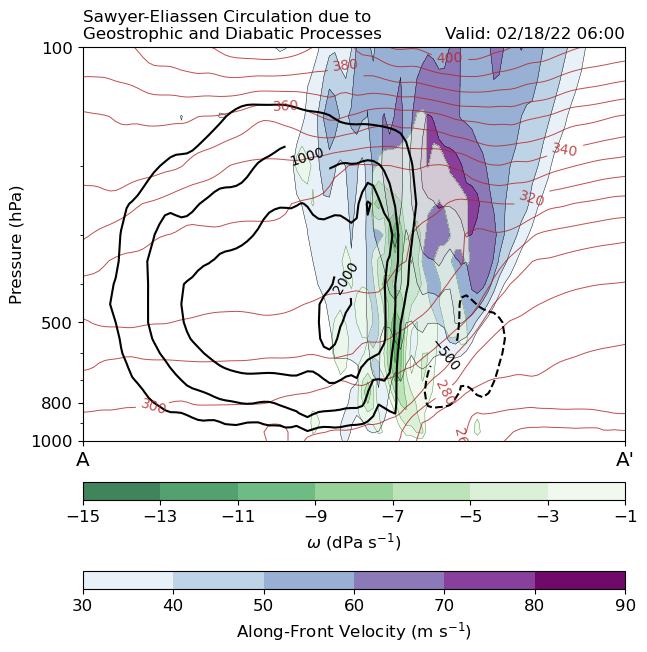

In [21]:
# Make a plot to visualize the circulation

plt.figure(figsize=(7,8))

# Set contouring intervals for along-front velocity, potential temperature, vertical velocity
# in the Sawyer-Eliassen circulation, and the Sawyer-Eliassen streamfunction.
# Avoid contouring 0 for the streamfunction.
clev_uprime = np.arange(30,100,10)
clev_tpot   = np.arange(200,500,10)
clev_wSE    = np.arange(-15.0,1.0,2.0)
clev_psi    = np.append(np.arange(-3000,0,500),np.arange(500,3000,500))

# Add shading for the along-front velocity    
contf_uprime = plt.contourf(uprime.index, 
                            uprime.pressure_level, 
                            uprime, 
                            levels = clev_uprime, 
                            cmap = cm['BuPu'])
cbar_uprime = plt.colorbar(contf_uprime, orientation='horizontal', aspect=30, pad=0.02)
cbar_uprime.set_label(r'Along-Front Velocity (m s$^{-1}$)', fontsize='large')
cbar_uprime.ax.tick_params(labelsize='large')

# Add thin contour lines to help make shading of along-front velocity more visible
cont_uprime = plt.contour(xsect.index, 
                          xsect.pressure_level, 
                          uprime, 
                          levels = clev_uprime, 
                          linestyles='solid', 
                          linewidths=0.3, colors='k')

# Add contours pf potential temperature
cont_tpot = plt.contour(xsect['tpot'].index, 
                        xsect['tpot'].pressure_level, 
                        xsect['tpot'], 
                        levels = clev_tpot, 
                        linestyles='solid', 
                        linewidths=0.7, 
                        colors='firebrick', alpha=0.8)
plt.clabel(cont_tpot, levels=clev_tpot[::2], manual=False)

# Add shading of ascent generated by the circulation
# Multiply by 10 to convert to dPa/s
contf_wSE = plt.contourf(xsect.index, 
                        xsect.pressure_level, 
                        wSE*10, 
                        levels = clev_wSE, 
                        cmap = cm['Greens_r'], 
                        alpha=0.75)
cbar_wSE = plt.colorbar(contf_wSE, orientation='horizontal',aspect=30, pad=0.08)
cbar_wSE.set_label(r'$\omega$ (dPa s$^{-1}$)', fontsize='large')
cbar_wSE.ax.tick_params(labelsize='large')

# Add thin contour lines to help make shading of ascent more visible
cont_wSE = plt.contour(xsect.index, 
                       xsect.pressure_level,
                       wSE*10,
                       levels = clev_wSE, 
                       linestyles='solid', 
                       linewidths=0.3, 
                       colors='darkgreen', alpha=0.75)


# Add contours for the Sawyer-Eliassen streamfunction
# Convert psi to m(hPa)/s
psi_contour = plt.contour(psi_da.index, 
                          psi_da.pressure_level, 
                          psi_da/100, 
                          levels = clev_psi,
                          colors = 'black', 
                          linewidths=1.5)
plt.clabel(psi_contour, levels = clev_psi[1::2])

# Adjust y-axis to have inverted, log-scale pressure values
ax = plt.gca()
ax.invert_yaxis()
plt.yscale('log')
plt.ylabel('Pressure (hPa)',fontsize='large')
ax.tick_params(axis='y',labelsize='large')

# Manually set y-axis ticks
ax.set_yticks([1000, 800, 500, 100])
ax.set_yticklabels(['1000', '800', '500', '100'])
ax.yaxis.set_minor_formatter(NullFormatter())

# Label x axis with start (A) and end (A') of cross section
ax.set_xticks([0,int(max(xsect.index))])
ax.set_xticklabels(['A','A\''])
ax.tick_params(axis='x',labelsize='x-large')
    
# Add title according to forcing
forcing_titles = {'full'     : 'Geostrophic and Diabatic Processes',
                  'Q_g'      : 'Geostrophic Processes',
                  'Q_gST'    : 'Geostrophic Confluence',
                  'Q_gSH'    : 'Geostrophic Shearing',
                  'diabatic' : 'Diabatic Processes'}
ax.set_title('Sawyer-Eliassen Circulation due to\n'+forcing_titles[forcing], fontsize='large', loc='left')
ax.set_title('Valid: '+time, loc='right')

# Save plot
plt.savefig('SEcirc_'+forcing+'.pdf',facecolor='white')
plt.show()